In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("benchmark.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [3]:
unique_experiments = df[['model', 'num_nodes', 'num_processes', 'num_gpus', 'num_prompts', 'data_parallelism']].drop_duplicates().reset_index(drop=True)
unique_experiments_sorted = unique_experiments.sort_values(by=['model'], ascending=False).reset_index(drop=True)
unique_experiments_sorted

model  num_nodes  num_processes  num_gpus  num_prompts  \
0    falcon-7b          1              1         1            1   
1    falcon-7b          1              1         2            1   
2    falcon-7b          1              2         2            1   
3    falcon-7b          1              1         3            1   
4    falcon-7b          1              1         4            1   
5    falcon-7b          2              2         2          132   
6   falcon-40b          1              1         2            1   
7   falcon-40b          1              1         3            1   
8   falcon-40b          1              1         4            1   
9   falcon-40b          2              2         4          132   
10  falcon-40b          2              2         8          132   

           data_parallelism  
0                      none  
1                      none  
2                      none  
3                      none  
4                      none  
5   embarrassingly-parallel  
6                      none  
7                      none  
8                      none  
9   embarrassingly-parallel  
10  embarrassingly-parallel

In [4]:
def experiment_length(group):
    duration = group['timestamp'].max() - group['timestamp'].min()
    return duration

columns_to_group_by = ['model', 'num_nodes', 'num_processes', 'num_gpus', 'num_prompts', 'model_parallelism', 'data_parallelism']

experiment_lengths = df.groupby(columns_to_group_by).apply(experiment_length).reset_index(name='experiment_length')

print(experiment_lengths)


         model  num_nodes  num_processes  num_gpus  num_prompts  \
0   falcon-40b          1              1         2            1   
1   falcon-40b          1              1         3            1   
2   falcon-40b          1              1         4            1   
3   falcon-40b          1              1         4            1   
4   falcon-40b          2              2         4          132   
5   falcon-40b          2              2         8          132   
6    falcon-7b          1              1         1            1   
7    falcon-7b          1              1         2            1   
8    falcon-7b          1              1         3            1   
9    falcon-7b          1              1         4            1   
10   falcon-7b          1              2         2            1   
11   falcon-7b          2              2         2          132   

      model_parallelism         data_parallelism experiment_length  
0   accelerate-naive-mp                     none   0 days 0

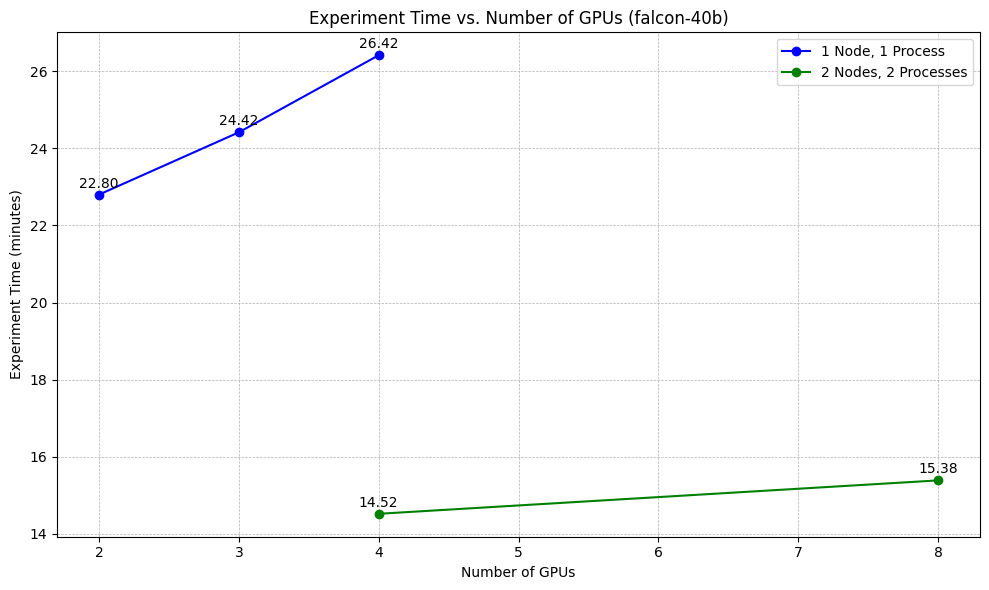

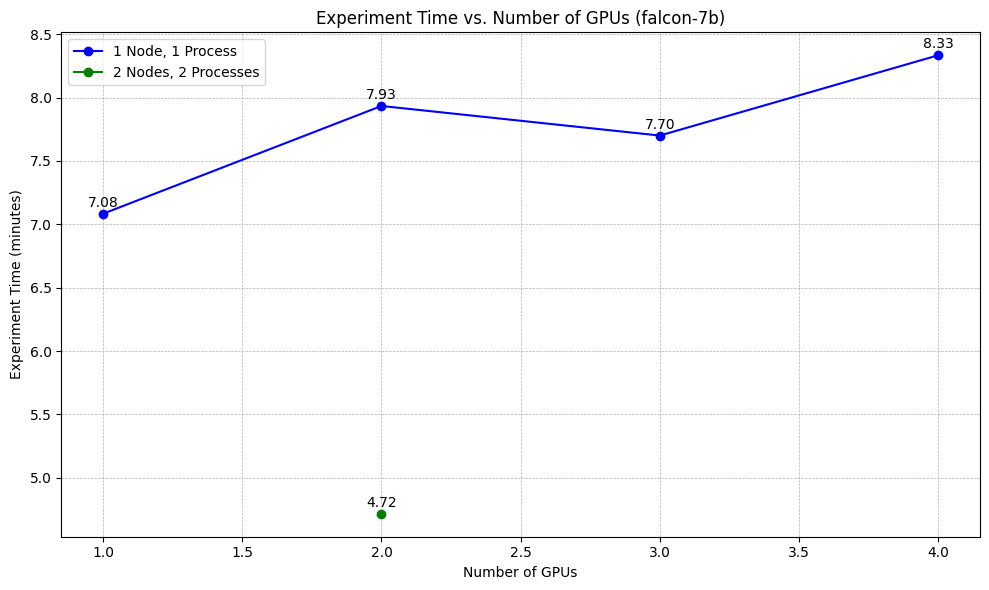

In [5]:
experiment_lengths['experiment_length'] = pd.to_timedelta(experiment_lengths['experiment_length'])

experiment_lengths['experiment_length'] = experiment_lengths['experiment_length'].dt.total_seconds() / 60

def plot_for_model(model_name):
    plt.figure(figsize=(10, 6))

    # Filter by model
    filtered_df = experiment_lengths[experiment_lengths['model'] == model_name]
    
    # Plot for num_nodes=1 and num_processes=1
    subset_1 = filtered_df[(filtered_df['num_nodes'] == 1) & (filtered_df['num_processes'] == 1) & (filtered_df['model_parallelism'] == 'accelerate-naive-mp')]
    if not subset_1.empty:
        plt.plot(subset_1['num_gpus'], subset_1['experiment_length'], marker='o', label='1 Node, 1 Process', color='blue')
        for i, row in subset_1.iterrows():
            plt.annotate(f"{row['experiment_length']:.2f}", 
                         (row['num_gpus'], row['experiment_length']),
                         textcoords="offset points",
                         xytext=(0, 5),
                         ha='center')

    # Plot for num_nodes=2 and num_processes=2
    subset_2 = filtered_df[(filtered_df['num_nodes'] == 2) & (filtered_df['num_processes'] == 2)  & (filtered_df['model_parallelism'] == 'accelerate-naive-mp')]
    if not subset_2.empty:
        plt.plot(subset_2['num_gpus'], subset_2['experiment_length'], marker='o', label='2 Nodes, 2 Processes', color='green')
        for i, row in subset_2.iterrows():
            plt.annotate(f"{row['experiment_length']:.2f}", 
                         (row['num_gpus'], row['experiment_length']),
                         textcoords="offset points",
                         xytext=(0, 5),
                         ha='center')
    plt.title(f'Experiment Time vs. Number of GPUs ({model_name})')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Experiment Time (minutes)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plot for each model
plot_for_model('falcon-40b')
plot_for_model('falcon-7b')

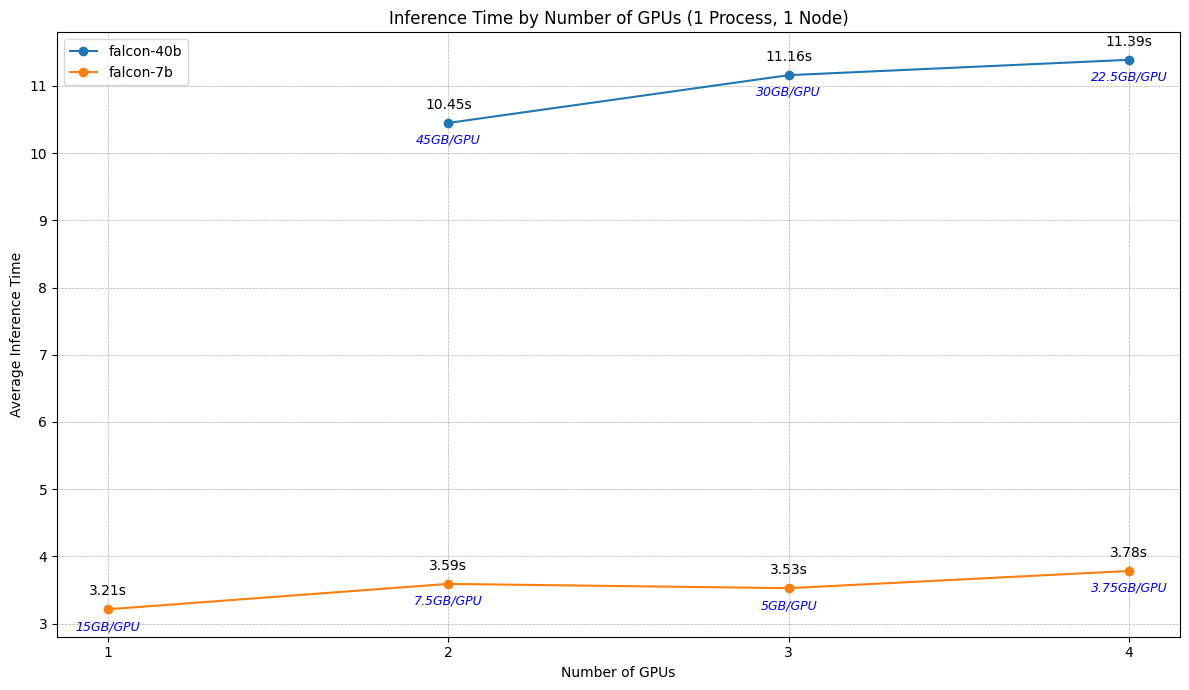

In [6]:
df_filtered = df[df['num_processes'] == 1]
# GPU memory requirements (in GB)
gpu_memory = {
    'falcon-7b': {1: 15, 2: 7.5, 3: 5, 4: 3.75},
    'falcon-40b': {2: 45, 3: 30, 4: 22.5}
}

df_grouped = df_filtered.groupby(['model', 'num_gpus']).inference_time.mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))

for model in df_grouped['model'].unique():
    subset = df_grouped[df_grouped['model'] == model]
    plt.plot(subset['num_gpus'], subset['inference_time'], marker='o', label=model)

    # Annotate with mean inference time
    for i, row in subset.iterrows():
        # Displaying inference time
        plt.annotate(f"{row['inference_time']:.2f}s", 
                     (row['num_gpus'], row['inference_time']),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
        # Displaying GPU memory requirement
        memory = gpu_memory[model][row['num_gpus']]
        plt.annotate(f"{memory}GB/GPU", 
                     (row['num_gpus'], row['inference_time']),
                     textcoords="offset points",
                     xytext=(0, -15),
                     ha='center', 
                     color='blue', fontsize=9, style='italic')

plt.title('Inference Time by Number of GPUs (1 Process, 1 Node)')
plt.xlabel('Number of GPUs')
plt.ylabel('Average Inference Time')
plt.xticks(df_grouped['num_gpus'].unique())
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

/home/isehgal2/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/isehgal2/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


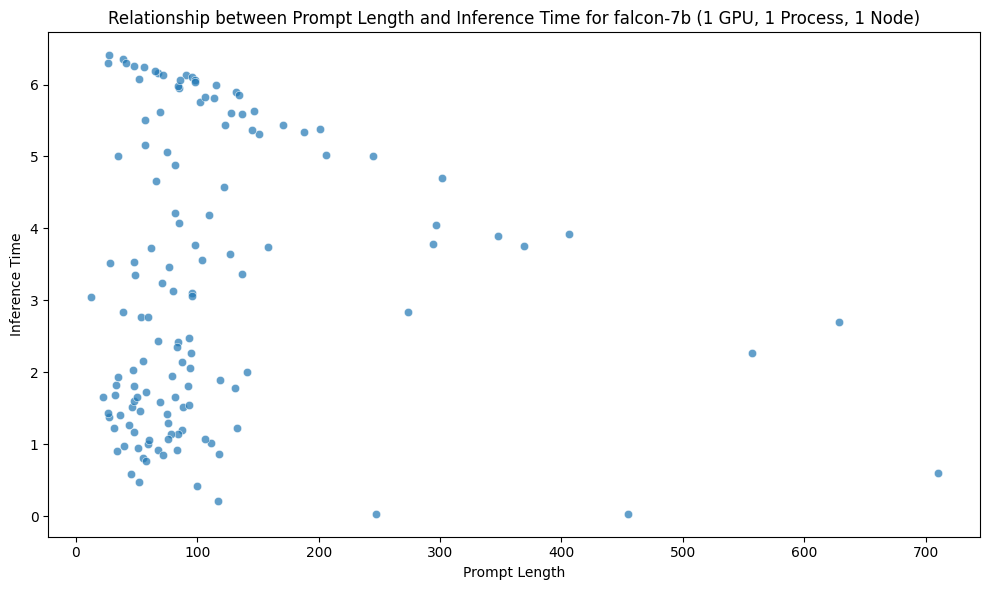

In [7]:
# Filter the data for falcon-7b, 1 process, 1 node, 1 gpu
subset = df[(df['model'] == 'falcon-7b') & (df['num_processes'] == 1) & (df['num_nodes'] == 1) & (df['num_gpus'] == 1)]

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset, x='prompt_len', y='inference_time', alpha=0.7)
plt.title('Relationship between Prompt Length and Inference Time for falcon-7b (1 GPU, 1 Process, 1 Node)')
plt.xlabel('Prompt Length')
plt.ylabel('Inference Time')
plt.tight_layout()
plt.show()

/home/isehgal2/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/isehgal2/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


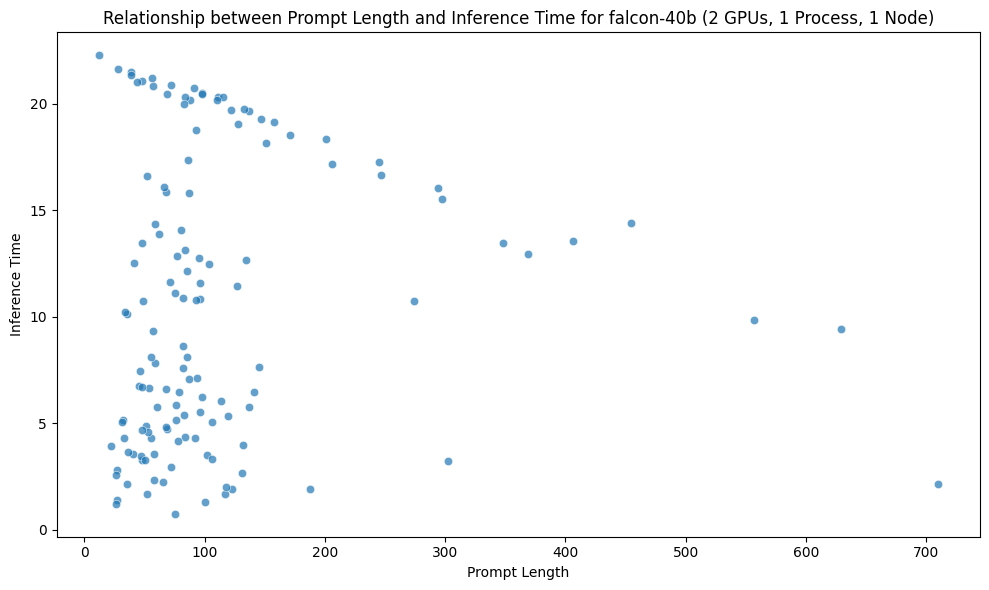

In [8]:
# Filter the data for falcon-4b, 2 gpus, 1 process, 1 node
subset = df[(df['model'] == 'falcon-40b') & (df['num_processes'] == 1) & (df['num_nodes'] == 1) & (df['num_gpus'] == 2)]

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset, x='prompt_len', y='inference_time', alpha=0.7)
plt.title('Relationship between Prompt Length and Inference Time for falcon-40b (2 GPUs, 1 Process, 1 Node)')
plt.xlabel('Prompt Length')
plt.ylabel('Inference Time')
plt.tight_layout()
plt.show()

In [9]:
deepspeed_df = pd.read_csv("benchmark-deepspeed.csv")
deepspeed_df['timestamp'] = pd.to_datetime(deepspeed_df['timestamp'])

In [10]:
unique_experiments = deepspeed_df[['model', 'num_nodes', 'num_processes', 'num_gpus', 'num_prompts', 'data_parallelism']].drop_duplicates().reset_index(drop=True)
unique_experiments_sorted = unique_experiments.sort_values(by=['model'], ascending=False).reset_index(drop=True)
unique_experiments_sorted

model  num_nodes  num_processes  num_gpus  num_prompts  \
0   falcon-7b          1              1         1            1   
1   falcon-7b          1              2         2            1   
2  falcon-40b          1              1         4            1   

  data_parallelism  
0             none  
1             none  
2             none

In [11]:
combined_df = pd.concat([df, deepspeed_df], ignore_index=True)

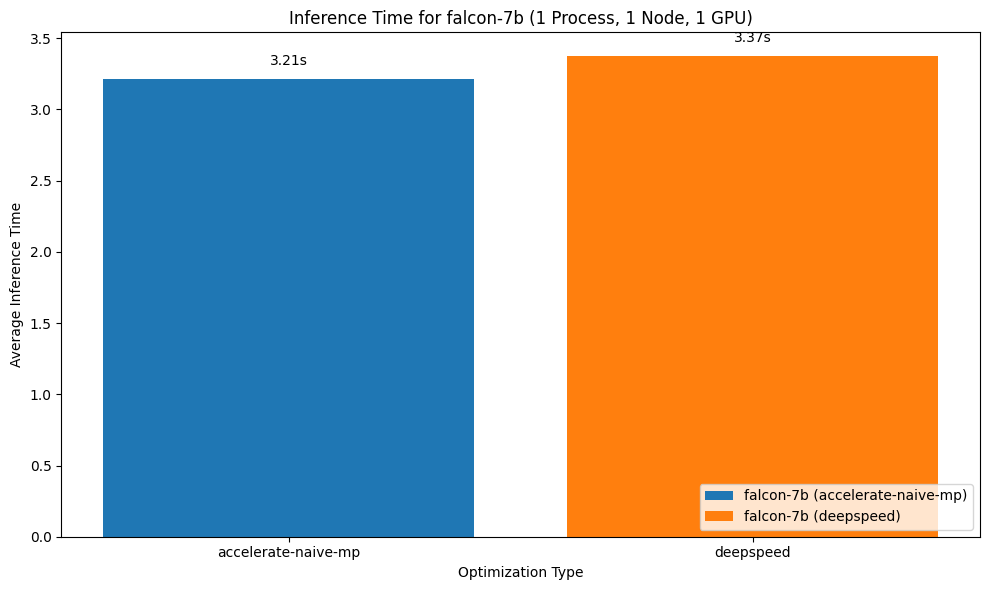

In [12]:
# Filter for falcon-7b, 1 process, 1 node, and 1 GPU
df_filtered = combined_df[(combined_df['model'] == 'falcon-7b') & 
                          (combined_df['num_processes'] == 1) & 
                          (combined_df['num_nodes'] == 1) & 
                          (combined_df['num_gpus'] == 1)]

# Group by model and parallelism type
df_grouped = df_filtered.groupby(['model', 'model_parallelism']).inference_time.mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plotting each group
for parallelism in df_grouped['model_parallelism'].unique():
    subset = df_grouped[df_grouped['model_parallelism'] == parallelism]
    plt.bar(subset['model_parallelism'], subset['inference_time'], label=f"falcon-7b ({parallelism})")
    
    # Annotate with mean inference time
    for i, row in subset.iterrows():
        plt.annotate(f"{row['inference_time']:.2f}s", 
                     (i, row['inference_time']),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')

plt.title('Inference Time for falcon-7b (1 Process, 1 Node, 1 GPU)')
plt.xlabel('Optimization Type')
plt.ylabel('Average Inference Time')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

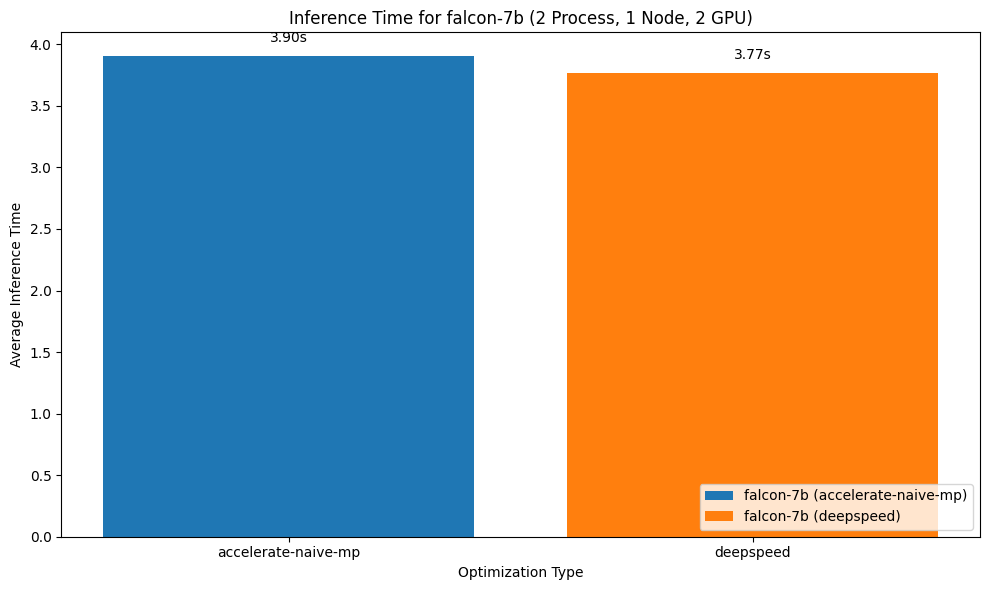

In [13]:
# Filter for falcon-7b, 1 process, 1 node, and 1 GPU
df_filtered = combined_df[(combined_df['model'] == 'falcon-7b') & 
                          (combined_df['num_processes'] == 2) & 
                          (combined_df['num_nodes'] == 1) & 
                          (combined_df['num_gpus'] == 2)]

# Group by model and parallelism type
df_grouped = df_filtered.groupby(['model', 'model_parallelism']).inference_time.mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plotting each group
for parallelism in df_grouped['model_parallelism'].unique():
    subset = df_grouped[df_grouped['model_parallelism'] == parallelism]
    plt.bar(subset['model_parallelism'], subset['inference_time'], label=f"falcon-7b ({parallelism})")
    
    # Annotate with mean inference time
    for i, row in subset.iterrows():
        plt.annotate(f"{row['inference_time']:.2f}s", 
                     (i, row['inference_time']),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')

plt.title('Inference Time for falcon-7b (2 Process, 1 Node, 2 GPU)')
plt.xlabel('Optimization Type')
plt.ylabel('Average Inference Time')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


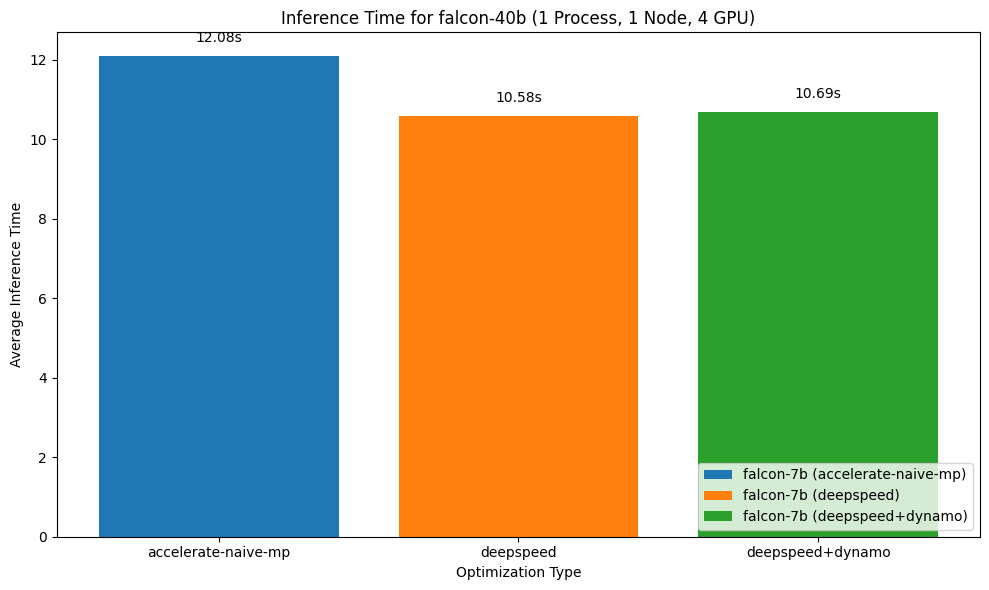

In [14]:
# Filter for falcon-40b, 1 process, 1 node, and 1 GPU
df_filtered = combined_df[(combined_df['model'] == 'falcon-40b') & 
                          (combined_df['num_processes'] == 1) & 
                          (combined_df['num_nodes'] == 1) & 
                          (combined_df['num_gpus'] == 4)]

# Group by model and parallelism type
df_grouped = df_filtered.groupby(['model', 'model_parallelism']).inference_time.mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plotting each group
for parallelism in df_grouped['model_parallelism'].unique():
    subset = df_grouped[df_grouped['model_parallelism'] == parallelism]
    plt.bar(subset['model_parallelism'], subset['inference_time'], label=f"falcon-7b ({parallelism})")
    
    # Annotate with mean inference time
    for i, row in subset.iterrows():
        plt.annotate(f"{row['inference_time']:.2f}s", 
                     (i, row['inference_time']),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')

plt.title('Inference Time for falcon-40b (1 Process, 1 Node, 4 GPU)')
plt.xlabel('Optimization Type')
plt.ylabel('Average Inference Time')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


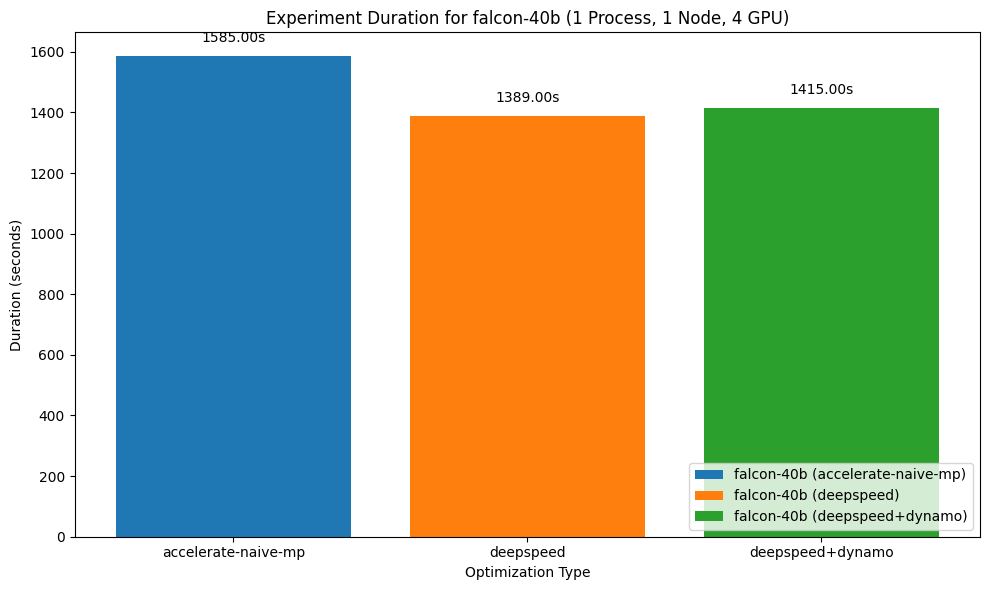

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the CSV is already read into combined_df
# Convert the timestamp column to datetime type
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Filter for falcon-40b, 1 process, 1 node, and 4 GPUs
df_filtered = combined_df[(combined_df['model'] == 'falcon-40b') & 
                          (combined_df['num_processes'] == 1) & 
                          (combined_df['num_nodes'] == 1) & 
                          (combined_df['num_gpus'] == 4)]

# Calculate experiment duration for each parallelism type
df_grouped_duration = df_filtered.groupby('model_parallelism').apply(lambda x: (x['timestamp'].max() - x['timestamp'].min()).seconds).reset_index()
df_grouped_duration.columns = ['model_parallelism', 'experiment_duration']

# Plotting experiment duration
plt.figure(figsize=(10, 6))

for parallelism, duration in zip(df_grouped_duration['model_parallelism'], df_grouped_duration['experiment_duration']):
    plt.bar(parallelism, duration, label=f"falcon-40b ({parallelism})")
    plt.annotate(f"{duration:.2f}s", 
                 (parallelism, duration),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center')

plt.title('Experiment Duration for falcon-40b (1 Process, 1 Node, 4 GPU)')
plt.xlabel('Optimization Type')
plt.ylabel('Duration (seconds)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
